In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import sklearn

In [ ]:
# Some preparing
df = pd.read_csv('hotel-reviews.csv', delimiter=',')
df['Is_Response'].replace({'happy':1, 'not happy':0}, inplace=True)

In [ ]:
df.head(n=5)

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,0
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,0
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,0
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,1
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,0


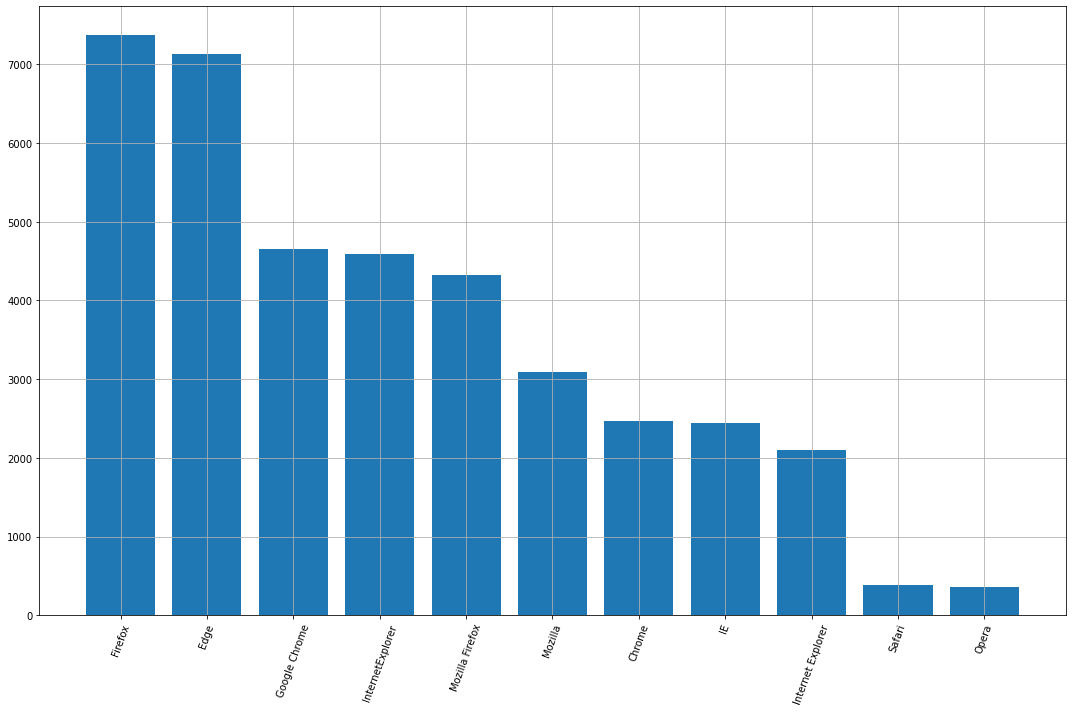

In [ ]:
# Just for fun let's see what browsers are used more often. I'am pretty confused that Edge is higher than Chrome:-)
plt.figure(figsize=(15, 10))
plt.bar(df['Browser_Used'].value_counts().index, df['Browser_Used'].value_counts())
plt.grid(True)
plt.xticks(rotation=70)
plt.tight_layout()

In [ ]:
df['Is_Response'].value_counts(normalize=True)
#Unbalanced - we will use stratification for splitting

1    0.681213
0    0.318787
Name: Is_Response, dtype: float64

In [ ]:
# Splitting the data with saving the same distribution character in both subsets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['Description'], df['Is_Response'], stratify=df['Is_Response'])

In [ ]:
Y_train.value_counts(normalize=True)

1    0.681222
0    0.318778
Name: Is_Response, dtype: float64

In [ ]:
Y_test.value_counts(normalize=True)

1    0.681188
0    0.318812
Name: Is_Response, dtype: float64

# **To solve this task we will use a Doc2Vec model with considering of tf_idf metrics.**

In [ ]:
import nltk
from nltk.corpus import stopwords

# building an array of list of words for each document
def d2v_tokenizer_text_stop_words(texts):
    vocabulary = []
    #i = 0
    for text in texts:
        textwords = []
        for sentenses in nltk.sent_tokenize(text):
            for word in nltk.word_tokenize(sentenses):
                word = word.lower()
                if len(word) <= 2:
                    continue
                if word in stopwords.words('english'):
                    continue
                textwords.append(word)
        vocabulary.append(textwords)
        #i += 1
        #print(i)
    return vocabulary

In [ ]:
text_words_array_xtrain = d2v_tokenizer_text_stop_words(X_train)
text_words_array_xtest = d2v_tokenizer_text_stop_words(X_test)

In [ ]:
# Creating documents for the training of Doc2Vec
from gensim.models.doc2vec import TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(text_words_array_xtrain)]

In [ ]:
# Creating a doc2vec model with tf_idf metric
from gensim.models import Doc2Vec
doctovec = Doc2Vec(tokenizer='tf_idf', documents=documents, vector_size=100)

In [ ]:
# vectorizing our dataset
X_train_vectorized = []

for text in text_words_array_xtrain:
    sum = np.zeros(100)
    for word in text:
        try:
            sum += doctovec.wv[word]
        except (KeyError):
            continue
    X_train_vectorized.append(sum)

In [ ]:
X_train_vectorized = np.array(X_train_vectorized)

In [ ]:
# vectorizing our dataset
X_test_vectorized = []

for text in text_words_array_xtest:
    sum = np.zeros(100)
    for word in text:
        try:
            sum += doctovec.wv[word]
        except (KeyError):
            continue
    X_test_vectorized.append(sum)

In [ ]:
X_test_vectorized = np.array(X_test_vectorized)

In [ ]:
# Visualize recieved data with the principal component analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=17)
X_train_pca = pca.fit_transform(X_train_vectorized)
pca.explained_variance_ratio_

array([0.50396271, 0.11215581])

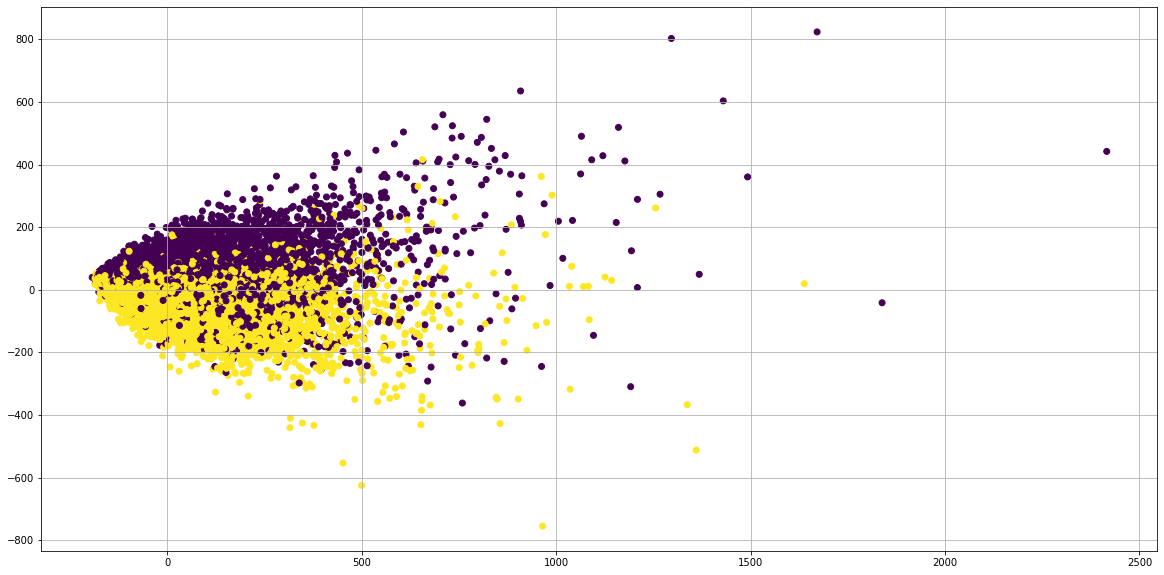

In [ ]:
# Points are not mixed too much since Doc2Vec works well
plt.figure(figsize=(20, 10))
plt.grid(True)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train)

## **For this task we will use a catboost algorithm from Yandex because such estimators as logistic regression and KNN shows lower results (checked earlier)**



In [ ]:
!pip install catboost

In [ ]:
import catboost

In [ ]:
cboost = catboost.CatBoostClassifier(learning_rate=0.1, n_estimators=400, depth=3)

In [ ]:
cboost.fit(X_train_vectorized, Y_train.values)

0:	learn: 0.6430104	total: 73.6ms	remaining: 29.3s
1:	learn: 0.5991094	total: 104ms	remaining: 20.7s
2:	learn: 0.5685139	total: 124ms	remaining: 16.5s
3:	learn: 0.5428021	total: 145ms	remaining: 14.4s
4:	learn: 0.5185941	total: 167ms	remaining: 13.2s
5:	learn: 0.5013010	total: 187ms	remaining: 12.3s
6:	learn: 0.4848627	total: 209ms	remaining: 11.7s
7:	learn: 0.4720247	total: 230ms	remaining: 11.3s
8:	learn: 0.4611844	total: 251ms	remaining: 10.9s
9:	learn: 0.4514634	total: 278ms	remaining: 10.8s
10:	learn: 0.4451016	total: 301ms	remaining: 10.6s
11:	learn: 0.4380223	total: 323ms	remaining: 10.4s
12:	learn: 0.4320926	total: 345ms	remaining: 10.3s
13:	learn: 0.4278936	total: 366ms	remaining: 10.1s
14:	learn: 0.4231877	total: 387ms	remaining: 9.94s
15:	learn: 0.4189672	total: 408ms	remaining: 9.78s
16:	learn: 0.4147770	total: 430ms	remaining: 9.7s
17:	learn: 0.4109523	total: 452ms	remaining: 9.59s
18:	learn: 0.4084067	total: 472ms	remaining: 9.46s
19:	learn: 0.4057080	total: 496ms	remaini

In [ ]:
#catboost works well!
cboost.score(X_test_vectorized, Y_test.values)

0.8532826466659817

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test.values, cboost.predict_proba(X_test_vectorized)[:, 1])
#roc_auc_score is much better than accuracy

0.9148310227683131